### ====== Loading, Reconstructing and Visualizing the fastMRI Prostate dataset ====== 

#### To download the fastMRI prostate dataset: https://fastmri.med.nyu.edu/

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import h5py
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import xml.etree.ElementTree as etree
from fastmri_prostate.reconstruction.t2.prostate_t2_recon_torch import t2_reconstruction
from fastmri_prostate.reconstruction.dwi.prostate_dwi_recon_torch import dwi_reconstruction
from fastmri_prostate.data.mri_data import load_file_T2, load_file_dwi, save_recon
import warnings
import os
warnings.filterwarnings('ignore')

import torch

In [4]:
#! Below: Add full folder path to downloaded fastMRI prostate data
fastMRI_dir = "<data>"

data_path_t2 = 'fastMRI_prostate_T2_IDS_001_020'
data_path_dwi = 'fastMRI_prostate_DIFF_IDS_001_011'

The fastMRI Prostate dataset is distributed as a set of HDF5 files that can be read with the h5py package

In [5]:
fname_t2 = os.path.join(fastMRI_dir, data_path_t2, 'file_prostate_AXT2_001.h5')
fname_dwi = os.path.join(fastMRI_dir,data_path_dwi, 'file_prostate_AXDIFF_001.h5')

## ---------------------------- T2  ----------------------------

### Example - how to load, reconstruct and visualize the T2 data. Data dimensions are explained here as well.

In [6]:
kspace, calibration_data, ismrmrd_header, reconstruction_rss, image_atts = load_file_T2(fname_t2)

print("Sizes of the array fields in the fastMRI prostate T2 file:")
print("kspace:", kspace.shape, ", calibration_data:", calibration_data.shape, ", reconstruction_rss:", reconstruction_rss.shape)

Sizes of the array fields in the fastMRI prostate T2 file:
kspace: (3, 30, 20, 640, 451) , calibration_data: (30, 20, 640, 32) , reconstruction_rss: (30, 320, 320)


Description of fields in the fastMRI prostate T2 file:

- "ismrmrd_header" => ISMRMRD header => scan acquisition parameters (https://ismrmrd.github.io/apidocs/1.5.0/)
- "kspace" => T2 raw k-space with dimensions => averages, slices, coils, readout, phase
- "reconstruction_rss" => Reconstructed T2 image volume with dimensions => slices, x, y
- "calibration_data" => Calibration scan acquired with dimensions => slices, coils, readout, phase

#### T2 reconstruction takes as input the kspace, calibration data and the ISMRMRD header => to outputs a dictionary containing the reconstructed image

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# put tensors on appropriate device
kspace = torch.tensor(kspace, device=device)
calibration_data = torch.tensor(calibration_data, device=device)


In [8]:
%%time
img_dict_t2 = t2_reconstruction(kspace, calibration_data, ismrmrd_header)
print("Size of reconstructed data:")
print(img_dict_t2['reconstruction_rss'].shape)

Size of reconstructed data:
torch.Size([30, 320, 320])
CPU times: user 24.3 s, sys: 8.98 s, total: 33.3 s
Wall time: 22.1 s


### Plotting the reconstructed T2 image, which is the same as 'reconstruction_rss' present in the h5 file

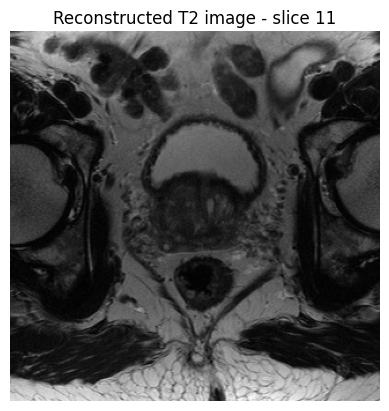

In [9]:
def display_t2_slice(img, slice_num):
    plt.imshow(img[slice_num, :, :] , cmap='gray')
    plt.title("Reconstructed T2 image - slice 11")
    plt.axis("off")
display_t2_slice(img_dict_t2['reconstruction_rss'], 10)

## ---------------------------- DWI  ----------------------------

### Example - how to load, reconstruct and visualize the DWI data. Data dimensions are explained here as well.

In [10]:
kspace, calibration_data, coil_sens_maps, ismrmrd_header = load_file_dwi(fname_dwi)

print("Sizes of the array fields in the fastMRI prostate DWI file:")
print("kspace:", kspace.shape, ", calibration_data:", calibration_data.shape, ", coil_sens_maps:", coil_sens_maps.shape)

Sizes of the array fields in the fastMRI prostate DWI file:
kspace: (50, 30, 20, 200, 150) , calibration_data: (30, 20, 200, 32) , coil_sens_maps: (30, 20, 200, 150)


Description of fields in the fastMRI prostate DWI file:

- "ismrmrd_header" => ISMRMRD header => scan acquisition parameters (https://ismrmrd.github.io/apidocs/1.5.0/)
- "kspace" => T2 raw k-space with dimensions => diffusion*, slices, coils, readout, phase
- "calibration_data" => Calibration scan acquired with dimensions => slices, coils, readout, phase
- "coil_sens_maps" => Coil sensitivity maps calculated using ESPIRIT with dimensions  => slices, coils, readout, phase

*diffusion dimension is comprised of multiple averages for different B strengths, they can be parsed out in the following way:

- B0_avg1   => kspace[0,:]
- B0_avg2   => kspace[1,:]
- B50x_avg1 => kspace[2,:]
- B50x_avg2 => kspace[8,:]
- B50x_avg3 => kspace[14,:]
- B50x_avg4 => kspace[20,:]
- B50y_avg1 => kspace[3,:]
- B50y_avg2 => kspace[9,:]
- B50y_avg3 => kspace[15,:]
- B50y_avg4 => kspace[21,:]
- B50z_avg1 => kspace[4,:]
- B50z_avg2 => kspace[10,:]
- B50z_avg3 => kspace[16,:]
- B50z_avg4 => kspace[22,:]
- B1000x_avg1 => kspace[5,:]
- B1000x_avg2 => kspace[11,:]
- B1000x_avg3 => kspace[17,:]
- B1000x_avg4 => kspace[23,:]
- B1000x_avg5 => kspace[26,:]
- B1000x_avg6 => kspace[29,:]
- B1000x_avg7 => kspace[32,:]
- B1000x_avg8 => kspace[35,:]
- B1000x_avg9 => kspace[38,:]
- B1000x_avg10 => kspace[41,:]
- B1000x_avg11 => kspace[44,:]
- B1000x_avg12 => kspace[47,:]
- B1000y_avg1 => kspace[6,:]
- B1000y_avg2 => kspace[12,:]
- B1000y_avg3 => kspace[18,:]
- B1000y_avg4 => kspace[24,:]
- B1000y_avg5 => kspace[27,:]
- B1000y_avg6 => kspace[30,:]
- B1000y_avg7 => kspace[33,:]
- B1000y_avg8 => kspace[36,:]
- B1000y_avg9 => kspace[39,:]
- B1000y_avg10 => kspace[42,:]
- B1000y_avg11 => kspace[45,:]
- B1000y_avg12 => kspace[48,:]
- B1000z_avg1 => kspace[7,:]
- B1000z_avg2 => kspace[13,:]
- B1000z_avg3 => kspace[19,:]
- B1000z_avg4 => kspace[25,:]
- B1000z_avg5 => kspace[28,:]
- B1000z_avg6 => kspace[31,:]
- B1000z_avg7 => kspace[34,:]
- B1000z_avg8 => kspace[37,:]
- B1000z_avg9 => kspace[40,:]
- B1000z_avg10 => kspace[43,:]
- B1000z_avg11 => kspace[46,:]
- B1000z_avg12 => kspace[49,:]

#### DWI reconstruction takes as input the kspace, calibration data, coil sensitivity maps and the ISMRMRD header => to outputs a dictionary containing the reconstructed images

In [11]:

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# put tensors on appropriate device
ismrmrd_header = {k: torch.tensor(v, device=device) for k, v in ismrmrd_header.items()}
kspace = torch.tensor(kspace, device=device)
calibration_data = torch.tensor(calibration_data, device=device)
coil_sens_maps = torch.tensor(coil_sens_maps, device=device)

In [12]:
%%time
img_dict_dwi = dwi_reconstruction(kspace, calibration_data, coil_sens_maps, ismrmrd_header)
print("Size of B50x image (as an example):")
print(img_dict_dwi['b50x'].shape)
print("Size of ADC map (as an example):")
print(img_dict_dwi['adc_map'].shape)

changed
Size of B50x image (as an example):
torch.Size([30, 100, 100])
Size of ADC map (as an example):
torch.Size([30, 100, 100])
CPU times: user 49.1 s, sys: 72.9 ms, total: 49.2 s
Wall time: 40.4 s


### Plotting the reconstructed DWI images, which contained by the same field names in the h5 file

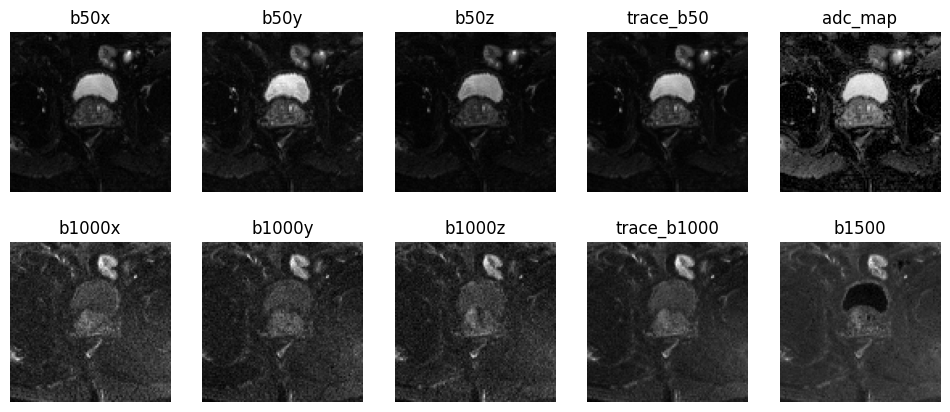

In [24]:
def display_dwi_slice(dwi_recons, slice_num):
    _, ax = plt.subplots(2, 5, figsize=(12,5))
    
    for idx, k in enumerate(['b50x', 'b50y', 'b50z', 'trace_b50', 'adc_map']):
        if type(dwi_recons[k]) == torch.Tensor:
            ax[0][idx].imshow(dwi_recons[k][slice_num, :, :].cpu(), cmap='gray')
        else:
            ax[0][idx].imshow(dwi_recons[k][slice_num, :, :], cmap='gray')
        ax[0][idx].title.set_text(k)
        ax[0][idx].axis("off")
    
    for idx, k in enumerate(['b1000x', 'b1000y', 'b1000z', 'trace_b1000', 'b1500']):
        if type(dwi_recons[k]) == torch.Tensor:
            ax[1][idx].imshow(dwi_recons[k][slice_num, :, :].cpu().numpy(), cmap='gray')
        else:
            ax[1][idx].imshow(dwi_recons[k][slice_num, :, :], cmap='gray')
        ax[1][idx].title.set_text(k)
        ax[1][idx].axis("off")

        
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

display_dwi_slice(img_dict_dwi, 10)